In [1]:
import pandas as pd
from scipy.signal import detrend as sp_detrend
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import requests


# Introduction to python for hydrologists &mdash; pandas

## Fourier analysis - so nerdy. so fun
https://youtu.be/spUNpyF58BY

## read in the daily values for the entire history of Lee's Ferry

In [2]:
dv_url = 'http://waterservices.usgs.gov/nwis/dv/?format=rdb'
dv_url += '&sites={0}'.format('09380000')
#dv_url += '&startDT=2010-01-01'
dv_url += '&startDT=1880-01-01'
#dv_url += '&endDT=2018-01-17'
dv_url += '&parameterCd=00060'
print(dv_url)


http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060


In [3]:
print ('reading data')
dv_file = requests.get(dv_url)
if not os.path.exists(os.path.join('data','pandas')):
    os.mkdir(os.path.join('data','pandas'))
with open(os.path.join('data','pandas','Lees Ferry.dat'), 'w') as ofp:
    for carp in dv_file:
        ofp.write(carp.decode())

reading data


In [4]:
NWISfilename = os.path.join('data','pandas','Lees Ferry.dat')
reconnoiter = open(NWISfilename, 'r').readlines()
for i in np.arange(60):
    print (reconnoiter[i].rstrip())

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database may not
# have received Director's approval.  Any such data values are qualified as provisional and
# are subject to revision.  Provisional data are released on the condition that neither the
# USGS nor the United States Government may be held liable for any damages resulting from its use.
#  Go to http://help.waterdata.usgs.gov/policies/provisional-data-statement for more information.
#
# File-format description:  http://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: http://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2018-03-19 13:48:30 -04:00	(natwebvaas01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 09380000 COLORADO RIVER AT LEES FERRY, AZ
# -----------------------------------------------

In [5]:
numhash = 0 #let's use the as the counter
for line in reconnoiter:
    if line.startswith('#'):
        numhash +=1
    else:
        break
        
print (numhash)

30


# Read in the time series

In [6]:
colnames = reconnoiter[numhash].rstrip().split()
colnames[3] = 'Q'

df_all = pd.read_csv(os.path.join('data','pandas','Lees Ferry.dat'),
                      sep='\t',
                      skiprows = numhash+2,
                      names = colnames,
                      parse_dates = True,
                      index_col = 2)

## we have to detrend the data for `fft` to work properly. care why? read this: https://groups.google.com/forum/#!topic/comp.dsp/kYDZqetr_TU

## how do we do this? python is "batteries included" https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html

## doesn't look different, but a linear trend was subtracted

In [7]:
df_all['Q_detrend'] = sp_detrend(df_all.Q)

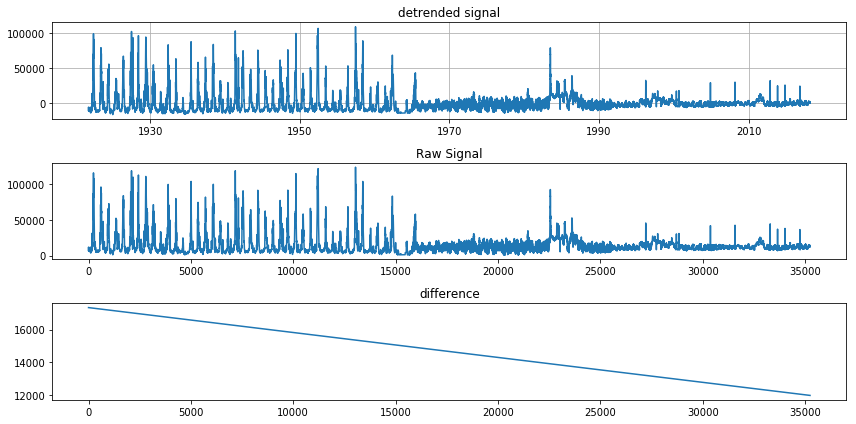

In [8]:
N = len(df_all)
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
plt.plot(df_all.Q_detrend)
plt.title('detrended signal')
plt.grid()

plt.subplot(3,1,2)
plt.plot(range(len(df_all)),df_all.Q)
plt.title('Raw Signal')


plt.subplot(3,1,3)
plt.plot(range(len(df_all)),df_all.Q-df_all.Q_detrend)
plt.title('difference')


plt.tight_layout()

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


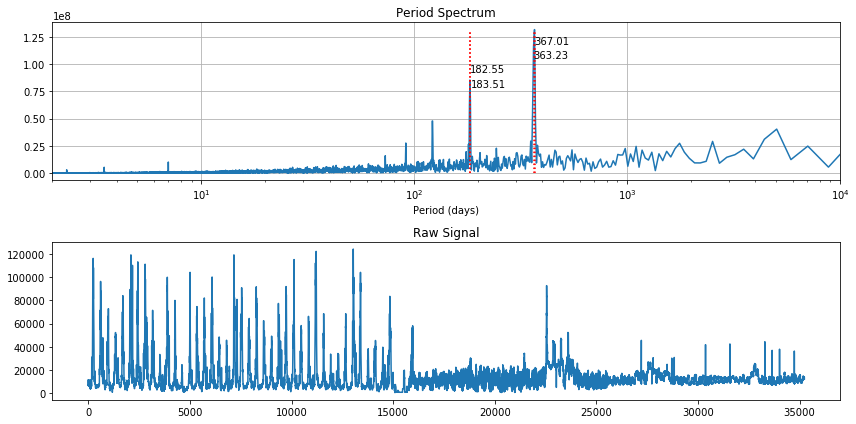

In [9]:
N = len(df_all)
yf = np.fft.fft(df_all.Q_detrend)
yf = np.abs(yf[:int(N/2)])
# get the right frequency 
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html#numpy.fft.fftfreq
d = 1. # day
f = np.fft.fftfreq(N,d)[:int(N/2)]
per = 1./f # days
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(2,1,1)
plt.plot(per, yf)
plt.xscale('log')

top4=np.argsort(yf)[-4:]
j=0.6
for i in top4:
    plt.plot([per[i],per[i]],[0,np.max(yf)],'r:')
    plt.text(per[i],j*np.max(yf),'{0:.2f}'.format(per[i]))
    j+=0.1

plt.title('Period Spectrum')
plt.grid()
ax.set_xlabel('Period (days)')
plt.xlim([0, 1e4])


plt.subplot(2,1,2)
plt.plot(range(len(df_all)),df_all.Q)
plt.title('Raw Signal')
plt.tight_layout()

## look only at years prior to Glen Canyon dam filling

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


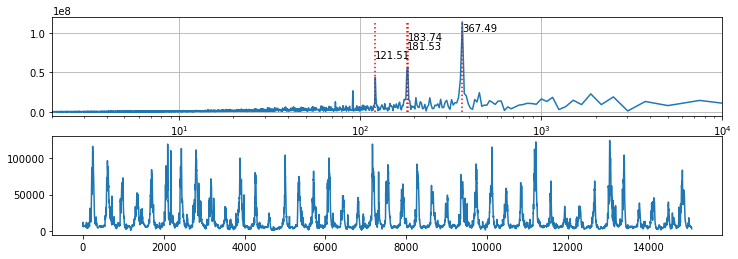

In [10]:
df = df_all.loc[df_all.index.year<1963].copy()
N = len(df)
d = 1. # day
f = np.fft.fftfreq(N,d)[:int(N/2)]
per = 1./f # days

yf_predam = np.fft.fft(sp_detrend(df.Q))
yf_predam = np.abs(yf_predam[:int(N/2)])

fig = plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(per,yf_predam)
top4=np.argsort(yf_predam)[-4:]
j=0.6
for i in top4:
    plt.plot([per[i],per[i]],[0,np.max(yf_predam)],'r:')
    plt.text(per[i],j*np.max(yf_predam),'{0:.2f}'.format(per[i]))
    j+=0.1

plt.xscale('log')

plt.grid()
plt.xlim([0,1e4])
plt.subplot(2,1,2)
plt.plot(range(len(df)),df.Q)

## did things change after the dam filled up in 1963?

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


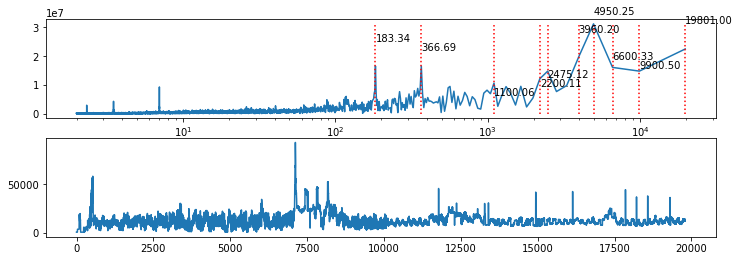

In [11]:
df = df_all.copy()
df = df.loc[df.index.year>1963]
N = len(df)
d = 1. # day
f = np.fft.fftfreq(N,d)[:int(N/2)]
per = 1./f # days
yf_postdam = np.fft.fft(sp_detrend(df.Q))
yf_postdam = np.abs(yf_postdam[:int(N/2)])
fig = plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(per,yf_postdam)

top10=np.argsort(yf_postdam)[-10:]
j=0.2
for i in top10:
    plt.plot([per[i],per[i]],[0,np.max(yf_postdam)],'r:')
    plt.text(per[i],j*np.max(yf_postdam),'{0:.2f}'.format(per[i]))
    j+=0.1

plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(range(len(df)),df.Q)
#plt.xlim([0,2500])

## in the heady days of grunge?

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


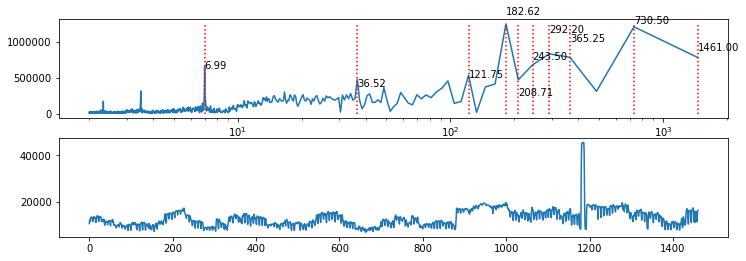

In [12]:
df = df_all.copy()
df = df.loc[(df.index.year>=1993) & (df.index.year<=1996)]
N = len(df)
d = 1. # day
f = np.fft.fftfreq(N,d)[:int(N/2)]
per = 1./f # days
yf_postdam = np.fft.fft(sp_detrend(df.Q))
yf_postdam = np.abs(yf_postdam[:int(N/2)])
fig = plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(per,yf_postdam)

top10=np.argsort(yf_postdam)[-10:]
j=0.2
for i in top10:
    plt.plot([per[i],per[i]],[0,np.max(yf_postdam)],'r:')
    plt.text(per[i],j*np.max(yf_postdam),'{0:.2f}'.format(per[i]))
    j+=0.1

plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(range(len(df)),df.Q)


## what's up with a dominant frequency of 7 days?

## let's check out a couple weeks of the signal

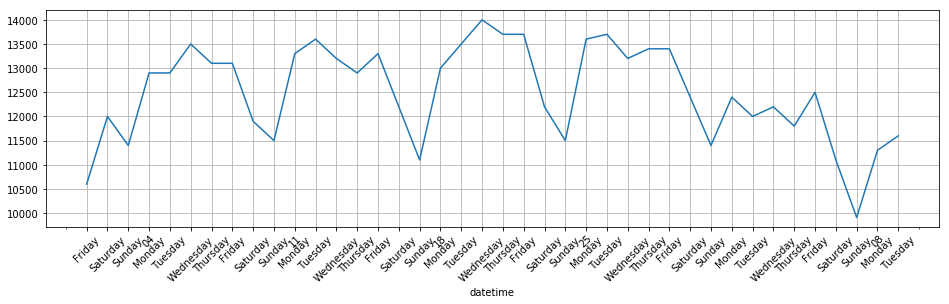

In [13]:
plt.figure(figsize=(16,4))
cfreq = 40
df.iloc[:cfreq].Q.plot(rot=45, grid=True)
plt.xticks(df.iloc[:cfreq].index,df.iloc[:cfreq].index.weekday_name);

## looks like power management. similar these days?

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


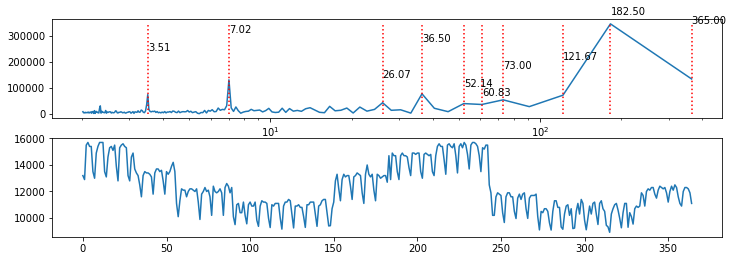

In [14]:
df = df_all.copy()
df = df.loc[(df.index.year>=2017) & (df.index<'2018-01-1')]
N = len(df)
d = 1. # day
f = np.fft.fftfreq(N,d)[:int(N/2)]
per = 1./f # days
yf_postdam = np.fft.fft(sp_detrend(df.Q))
yf_postdam = np.abs(yf_postdam[:int(N/2)])
fig = plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(per,yf_postdam)

top10=np.argsort(yf_postdam)[-10:]
j=0.2
for i in top10:
    plt.plot([per[i],per[i]],[0,np.max(yf_postdam)],'r:')
    plt.text(per[i],j*np.max(yf_postdam),'{0:.2f}'.format(per[i]))
    j+=0.1

plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(range(len(df)),df.Q)

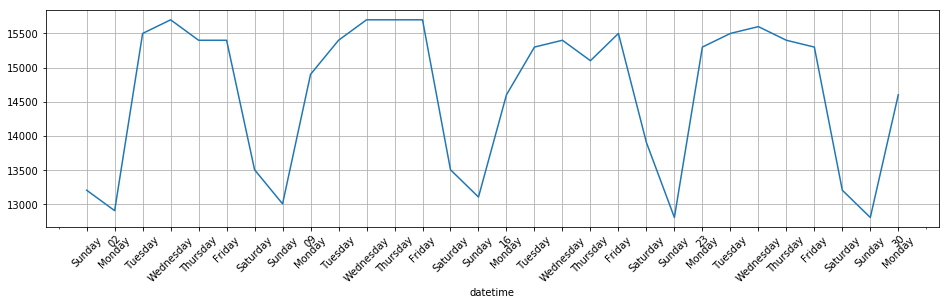

In [15]:
plt.figure(figsize=(16,4))
cfreq = 30
df.iloc[:cfreq].Q.plot(rot=45, grid=True)
plt.xticks(df.iloc[:cfreq].index,df.iloc[:cfreq].index.weekday_name);